In [1]:
import torch.nn.functional as F
import torch
import numpy as np
from pathlib import Path
import plotly.graph_objs as go
import matplotlib.pyplot as plt


from initialization import NeuralSurfaceReconstruction, grid_doubling

In [2]:
nsr = NeuralSurfaceReconstruction(
    data=Path("../data/calculator"),
    device=torch.device("cuda:0"),
)
len(nsr.images)

703

In [26]:
photo_loss = torch.nn.HuberLoss(reduction="sum")

optimizer = torch.optim.Adam(nsr.model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                       patience=5, factor=0.1)

In [27]:
torch.autograd.set_detect_anomaly(True)

EPOCHS = 1
IMAGE_EPOCHS = 100

rendered_image = []


for epoch in range(0, EPOCHS):

    for viewpoint in range(1): #len(nsr.images)//10):
        
        print(f"VIEWPOINT: {viewpoint}")

        # HxWx3=Nx3, NxTx3, 2xN
        tp, st, v = nsr.query_data(viewpoint,
                                   N_query_points=100, t_size=0.15,
                                   _pixel_grid_width_step=1.0,
                                   _pixel_grid_height_step=1.0)

        for image_epoch in range(0, IMAGE_EPOCHS):
            total_loss = 0.0

            # MINIBATCH_SIZE = st.shape[0]//4
            # for i in range(0, st.shape[0], MINIBATCH_SIZE):
            optimizer.zero_grad()

            output = nsr.model(st, v)
            output = output.cpu() #.detach()

            # print(output.requires_grad)

            # photo_loss = torch.linalg.norm(tp[i:i+MINIBATCH_SIZE]-output, dim=1).sum()
            # photo_loss.backward()

            loss = photo_loss(tp, output)
            loss.backward()

            total_loss += loss.item()

            optimizer.step()
        
        
            scheduler.step(total_loss)

        
            print(total_loss)
            print(scheduler.get_last_lr())

    if epoch == EPOCHS-1:
        rendered_image.append(output)



VIEWPOINT: 0
116779.5234375
[0.01]
78967.5078125
[0.01]
48240.58984375
[0.01]
30605.93359375
[0.01]
17452.150390625
[0.01]
13967.595703125
[0.01]
12430.650390625
[0.01]
15518.6923828125
[0.01]
17918.166015625
[0.01]
19253.03125
[0.01]
19827.033203125
[0.01]
17715.8671875
[0.01]
16816.611328125
[0.001]
13824.8408203125
[0.001]
14541.673828125
[0.001]
13371.1748046875
[0.001]
13985.0126953125
[0.001]
12810.44140625
[0.001]
13342.30859375
[0.0001]
12207.9033203125
[0.0001]
12970.8701171875
[0.0001]
12144.7626953125
[0.0001]
12898.138671875
[0.0001]
12077.458984375
[0.0001]
12821.21875
[0.0001]
12007.0556640625
[0.0001]
12741.1640625
[0.0001]
11934.40625
[0.0001]
12658.830078125
[0.0001]
11860.2001953125
[0.0001]
12574.91015625
[0.0001]
11784.9970703125
[0.0001]
12489.97265625
[0.0001]
11709.255859375
[0.0001]
12404.48046875
[0.0001]
11633.3447265625
[0.0001]
12318.8173828125
[0.0001]
11557.5810546875
[0.0001]
12233.302734375
[0.0001]
11482.2197265625
[0.0001]
12148.18359375
[0.0001]
11407

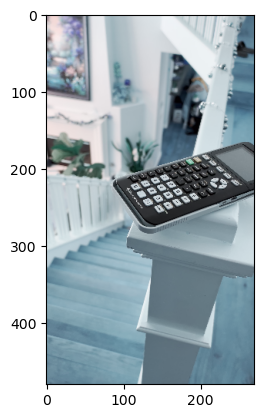

In [28]:
plt.imshow(tp.detach().reshape((1080//4, 1920//4, 3)).permute(1,0,2).float().numpy())

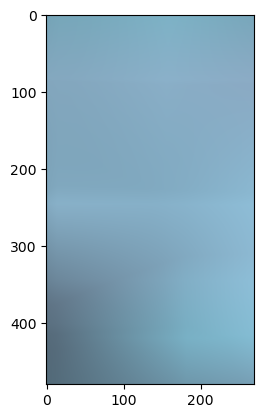

In [29]:
img = output.reshape((1080//4, 1920//4, 3)).permute(1,0,2)

plt.imshow(img.detach().numpy())

In [17]:
output.reshape((1080//2, 1920//2, 3))

tensor([[[0.5995, 0.6461, 0.6564],
         [0.5975, 0.6435, 0.6541],
         [0.5981, 0.6441, 0.6547],
         ...,
         [0.1300, 0.1385, 0.1457],
         [0.1297, 0.1382, 0.1453],
         [0.1293, 0.1378, 0.1449]],

        [[0.6004, 0.6472, 0.6574],
         [0.5983, 0.6446, 0.6551],
         [0.5971, 0.6430, 0.6536],
         ...,
         [0.1299, 0.1384, 0.1455],
         [0.1295, 0.1380, 0.1452],
         [0.1292, 0.1377, 0.1448]],

        [[0.6012, 0.6482, 0.6584],
         [0.5992, 0.6457, 0.6561],
         [0.5971, 0.6431, 0.6537],
         ...,
         [0.1298, 0.1383, 0.1454],
         [0.1294, 0.1379, 0.1450],
         [0.1291, 0.1376, 0.1446]],

        ...,

        [[0.4671, 0.4910, 0.5062],
         [0.4702, 0.4942, 0.5095],
         [0.4730, 0.4972, 0.5126],
         ...,
         [0.3908, 0.4089, 0.4359],
         [0.3904, 0.4086, 0.4355],
         [0.3900, 0.4082, 0.4351]],

        [[0.4662, 0.4900, 0.5052],
         [0.4690, 0.4930, 0.5083],
         [0.

In [5]:
tp, st, v = nsr.query_data(70,
                            N_query_points=3, t_size=0.15,
                            _pixel_grid_width_step=1.0,
                            _pixel_grid_height_step=1.0)

output = nsr.model(st, v)

output
        

tensor(..., device='meta', size=(129600, 3), grad_fn=<AddBackward0>)

In [6]:
list(nsr.model.named_modules())

[('',
  NeuralSurfaceReconstructor(
    (s): S()
    (lo): L_o(
      (radiance_mlp_in): Linear(in_features=5, out_features=64, bias=True)
      (radiance_mlp_out): Linear(in_features=64, out_features=3, bias=True)
    )
  )),
 ('s', S()),
 ('lo',
  L_o(
    (radiance_mlp_in): Linear(in_features=5, out_features=64, bias=True)
    (radiance_mlp_out): Linear(in_features=64, out_features=3, bias=True)
  )),
 ('lo.radiance_mlp_in', Linear(in_features=5, out_features=64, bias=True)),
 ('lo.radiance_mlp_out', Linear(in_features=64, out_features=3, bias=True))]

In [7]:
output.grad_fn, nsr.model.parameters()

(<AddBackward0 at 0x2568b976140>,
 <generator object Module.parameters at 0x000002568CC6D7E0>)

In [4]:
from torchview import draw_graph

# torchviz.make_dot(output, nsr.model.named_parameters())

model_graph = draw_graph(nsr.model, input_size=[st.shape, v.shape], depth=1, device="meta")
model_graph.visual_graph

NameError: name 'st' is not defined

In [9]:
print(type(model_graph.visual_graph))

<class 'graphviz.graphs.Digraph'>


In [16]:
model_graph.visual_graph.render("./nsr_graph.png")


(process:24424): Pango-WARNING **: 09:38:03.421: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'nsr_graph.png.pdf'

In [10]:
model_graph = draw_graph(nsr.model.s, input_size=(st.shape[0], st.shape[2]), depth=2, device="meta")
model_graph.visual_graph.render("./S_graph.png")


(process:27400): Pango-WARNING **: 09:48:44.052: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'S_graph.png.pdf'

In [11]:
model_graph = draw_graph(nsr.model.lo, input_size=[(st.shape[0], st.shape[2]), v.shape], depth=2, device="meta")
model_graph.visual_graph.render("./Lo_graph.png")


(process:24908): Pango-WARNING **: 09:48:44.862: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'Lo_graph.png.pdf'

In [27]:
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
f = torch.tensor([True, False, False], requires_grad=False)
b = a[f]+10
c = a[~f]-10
d = torch.full(a.shape, 0.0)
d[f] = b
d[~f] = c

In [36]:
b, c, d

NameError: name 'b' is not defined

In [41]:
nsr.fg_V.grid_pos[0, :, 0, 0], nsr.fg_V.grid_pos[1, 0, :, 0], nsr.fg_V.grid_pos[2, 0, 0, :]

(tensor([-3.2500, -3.0500, -2.8500, -2.6500, -2.4500, -2.2500, -2.0500, -1.8500,
         -1.6500, -1.4500, -1.2500, -1.0500, -0.8500, -0.6500, -0.4500, -0.2500],
        device='cuda:0'),
 tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000, 1.2000, 1.4000, 1.6000,
         1.8000, 2.0000, 2.2000, 2.4000, 2.6000, 2.8000, 3.0000],
        device='cuda:0'),
 tensor([-1.0000, -0.8000, -0.6000, -0.4000, -0.2000,  0.0000,  0.2000,  0.4000,
          0.6000,  0.8000,  1.0000,  1.2000,  1.4000,  1.6000,  1.8000,  2.0000],
        device='cuda:0'))

In [6]:
nsr.fg_V.voxel_pos.shape[1]
print(nsr.fg_V.min_x, nsr.fg_V.max_x, nsr.fg_V.voxel_size*2)
print(nsr.fg_V.min_y, nsr.fg_V.max_y, nsr.fg_V.voxel_size*2)
print(nsr.fg_V.min_z, nsr.fg_V.max_z, nsr.fg_V.voxel_size*2)

tensor(-3.2500, device='cuda:0') tensor(-0.2500, device='cuda:0') 32
tensor(0., device='cuda:0') tensor(3., device='cuda:0') 32
tensor(-1., device='cuda:0') tensor(2., device='cuda:0') 32


In [30]:
newx, newy, newz = torch.meshgrid(
    torch.linspace(nsr.fg_V.min_x, nsr.fg_V.max_x, steps=nsr.fg_V.voxel_size*2),
    torch.linspace(nsr.fg_V.min_y, nsr.fg_V.max_y, steps=nsr.fg_V.voxel_size*2),
    torch.linspace(nsr.fg_V.min_z, nsr.fg_V.max_z, steps=nsr.fg_V.voxel_size*2),
    indexing="ij",
)

newc = torch.stack((newx, newy, newz))
newc[0, :, 0, 0], newc[1, 0, :, 0], newc[2, 0, 0, :]
# newx[:, 0, 0], newy[0, :, 0], newz[0, 0, :]

(tensor([-3.2500, -3.1532, -3.0565, -2.9597, -2.8629, -2.7661, -2.6694, -2.5726,
         -2.4758, -2.3790, -2.2823, -2.1855, -2.0887, -1.9919, -1.8952, -1.7984,
         -1.7016, -1.6048, -1.5081, -1.4113, -1.3145, -1.2177, -1.1210, -1.0242,
         -0.9274, -0.8306, -0.7339, -0.6371, -0.5403, -0.4435, -0.3468, -0.2500]),
 tensor([0.0000, 0.0968, 0.1935, 0.2903, 0.3871, 0.4839, 0.5806, 0.6774, 0.7742,
         0.8710, 0.9677, 1.0645, 1.1613, 1.2581, 1.3548, 1.4516, 1.5484, 1.6452,
         1.7419, 1.8387, 1.9355, 2.0323, 2.1290, 2.2258, 2.3226, 2.4194, 2.5161,
         2.6129, 2.7097, 2.8065, 2.9032, 3.0000]),
 tensor([-1.0000, -0.9032, -0.8065, -0.7097, -0.6129, -0.5161, -0.4194, -0.3226,
         -0.2258, -0.1290, -0.0323,  0.0645,  0.1613,  0.2581,  0.3548,  0.4516,
          0.5484,  0.6452,  0.7419,  0.8387,  0.9355,  1.0323,  1.1290,  1.2258,
          1.3226,  1.4194,  1.5161,  1.6129,  1.7097,  1.8065,  1.9032,  2.0000]))

In [20]:
nsr.fg_V.sdf, nsr.fg_V.sdf.shape

(tensor([[[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 0.9900,  ..., 1.0000, 1.0000, 1.0000],
            ...,
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
           [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            ...,
            [1.0000, 1.0000, 0.9900,  ..., 0.9900, 1.0000, 1.0000],
            [0.9900, 1.0000, 0.9900,  ..., 1.0000, 1.0000, 1.0000],
            [0.9900, 1.0000, 0.9900,  ..., 1.0000, 1.0000, 1.0000]],
 
           [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        

In [23]:
newsdf = F.interpolate(nsr.fg_V.sdf, scale_factor=(2, 2, 2), mode="nearest")  # , align_corners=True

In [31]:
newx.shape, newy.shape, newz.shape, newsdf.shape

(torch.Size([32, 32, 32]),
 torch.Size([32, 32, 32]),
 torch.Size([32, 32, 32]),
 torch.Size([1, 1, 32, 32, 32]))

In [33]:
(2,)*3

(2, 2, 2)

In [3]:
new_fg = grid_doubling(nsr.fg_V)
new_bg = grid_doubling(nsr.bg_V)

In [4]:
go.Figure(data=[
    # go.Scatter3d(
    #     x=nsr.fg_V.grid_pos[0].flatten().cpu().detach().numpy(),
    #     y=nsr.fg_V.grid_pos[1].flatten().cpu().detach().numpy(),
    #     z=nsr.fg_V.grid_pos[2].flatten().cpu().detach().numpy(),
    #     mode='markers',
    #     marker={
    #         'size': 10,
    #         "color": nsr.fg_V.sdf.flatten().cpu().detach().numpy(),
    #         'opacity': 0.3,
    #         "cmax": 1.0,
    #         "cmin": -1.0,
    #         "colorbar": {
    #             "thickness": 10,
    #         }
    #     }
    # ),
    # go.Scatter3d(
    #     x=nsr.bg_V.grid_pos[0].flatten().cpu().detach().numpy(),
    #     y=nsr.bg_V.grid_pos[1].flatten().cpu().detach().numpy(),
    #     z=nsr.bg_V.grid_pos[2].flatten().cpu().detach().numpy(),
    #     mode='markers',
    #     marker={
    #         'size': 10,
    #         "color": nsr.bg_V.sdf.flatten().cpu().detach().numpy(),
    #         'opacity': 0.2,
    #         "cmax": 1.0,
    #         "cmin": -1.0,
    #         # "colorbar": {
    #         #     "thickness": 10,
    #         # }
    #     }
    # ),
    go.Scatter3d(
        x=new_fg.grid_pos[0].flatten().cpu().detach().numpy(),
        y=new_fg.grid_pos[1].flatten().cpu().detach().numpy(),
        z=new_fg.grid_pos[2].flatten().cpu().detach().numpy(),
        mode='markers',
        marker={
            'size': 10,
            "color": new_fg.sdf.flatten().cpu().detach().numpy(),
            'opacity': 0.3,
            "cmax": 1.0,
            "cmin": -1.0,
            "colorbar": {
                "thickness": 10,
            }
        }
    ),
    go.Scatter3d(
        x=new_bg.grid_pos[0].flatten().cpu().detach().numpy(),
        y=new_bg.grid_pos[1].flatten().cpu().detach().numpy(),
        z=new_bg.grid_pos[2].flatten().cpu().detach().numpy(),
        mode='markers',
        marker={
            'size': 10,
            "color": new_bg.sdf.flatten().cpu().detach().numpy(),
            'opacity': 0.2,
            "cmax": 1.0,
            "cmin": -1.0,
            # "colorbar": {
            #     "thickness": 10,
            # }
        }
    ),
    # go.Scatter3d(
    #     x=st[:,:,0].flatten(),
    #     y=st[:,:,1].flatten(),
    #     z=st[:,:,2].flatten(),
    #     mode='markers',
    #     marker={
    #         'size': 3,
    #         'opacity': 1.0,
    #     }
    # ),
], layout=go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-30, 30]),  # Set x-axis range
        yaxis=dict(range=[-30, 30]),  # Set y-axis range
        zaxis=dict(range=[-30, 30])   # Set z-axis range
    ),
    scene_camera= dict(
        eye=dict(x=0.0, y=0.0, z=0.1)
    )
))

# Forward pass

In [3]:
nsr.fg_V.feat

tensor([[[[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

          [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

          [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000

In [32]:
tp, st, v = nsr.query_points_and_direction(0, N_query_points=100, t_size=0.15,
                                        _pixel_grid_width_step=100.0,
                                        _pixel_grid_height_step=100.0,
                                        _scale=1.0)

In [33]:
st_i = st[:, 50]

In [34]:
is_f, is_b = nsr.model.sector(st_i)

norm_fx_i = ((st_i[is_f]-nsr.model.fg_V.center)/nsr.model.fg_V.scale).float()
norm_fx_i = torch.flip(  # X Y Z -> Z Y X
    norm_fx_i[torch.newaxis, torch.newaxis, torch.newaxis],
    dims=[-1]
)

In [35]:
norm_fx_i

tensor([[[[[-0.7026, -0.9388, -0.9761],
           [-0.7037, -0.8551, -0.9738],
           [-0.7048, -0.7723, -0.9717],
           ...,
           [-0.7432,  0.8019,  0.3036],
           [-0.7442,  0.8825,  0.3060],
           [-0.7453,  0.9636,  0.3086]]]]])

In [36]:
f_feat_i = F.grid_sample(
    nsr.model.fg_V.feat, norm_fx_i,
    mode="bilinear", padding_mode="border", align_corners=True
).squeeze()  # CxN

In [37]:
nsr.model.fg_V.feat.shape, norm_fx_i.shape, f_feat_i.shape

(torch.Size([1, 3, 16, 16, 16]),
 torch.Size([1, 1, 1, 425, 3]),
 torch.Size([3, 425]))

In [38]:
torch.cat([f_feat_i, v[:, is_f]], axis=0)

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [1.7510, 1.7370, 1.7231,  ..., 1.4537, 1.4400, 1.4263],
        [1.6374, 1.6370, 1.6367,  ..., 1.4165, 1.4161, 1.4156]])

In [39]:
v

tensor([[1.8223, 1.8079, 1.7936,  ..., 1.3285, 1.3143, 1.2999],
        [1.7108, 1.7100, 1.7092,  ..., 1.4112, 1.4105, 1.4096]])

In [41]:
L_o = nsr.model.L_o(st_i, v)

In [43]:
L_o.shape

torch.Size([858, 3])

In [47]:
st_i.shape[0]

858

In [48]:
torch.full((st_i.shape[0],), 0.0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [22]:
go.Figure(data=[
    go.Scatter3d(
        x=nsr.fg_V.grid_pos[0].flatten(),
        y=nsr.fg_V.grid_pos[1].flatten(),
        z=nsr.fg_V.grid_pos[2].flatten(),
        mode='markers',
        marker={
            'size': 10,
            "color": nsr.fg_V.sdf.flatten(),
            'opacity': 0.3,
            "cmax": 1.0,
            "cmin": -1.0,
            "colorbar": {
                "thickness": 10,
            }
        }
    ),
    go.Scatter3d(
        x=nsr.bg_V.grid_pos[0].flatten(),
        y=nsr.bg_V.grid_pos[1].flatten(),
        z=nsr.bg_V.grid_pos[2].flatten(),
        mode='markers',
        marker={
            'size': 10,
            "color": nsr.bg_V.sdf.flatten(),
            'opacity': 0.2,
            "cmax": 1.0,
            "cmin": -1.0,
            # "colorbar": {
            #     "thickness": 10,
            # }
        }
    ),
    go.Scatter3d(
        x=st_i[:, 0],
        y=st_i[:, 1],
        z=st_i[:, 2],
        mode='markers',
        marker={
            'size': 3,
            "color": sdf_i,
            'opacity': 1.0,
            "cmax": 1.0,
            "cmin": -1.0,
        }
    ),
], layout=go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-30, 30]),  # Set x-axis range
        yaxis=dict(range=[-30, 30]),  # Set y-axis range
        zaxis=dict(range=[-30, 30])   # Set z-axis range
    ),
    scene_camera= dict(
        eye=dict(x=0.0, y=0.0, z=0.1)
    )
))

In [4]:
_, st, v = nsr.query_points_and_direction(700, N_query_points=100, t_size=0.15,
                                        _pixel_grid_width_step=100.0,
                                        _pixel_grid_height_step=100.0,
                                        _scale=1.0)
stx, sty, stz = np.hsplit(st.reshape(-1, 3), 3)

In [5]:
st_i = st[:, -1]

In [6]:
x_i = torch.tensor(st_i).float()
sdf_i = nsr.model.S(x_i)

In [7]:
go.Figure(data=[
    go.Scatter3d(
        x=nsr.fg_V.grid_pos[0].flatten(),
        y=nsr.fg_V.grid_pos[1].flatten(),
        z=nsr.fg_V.grid_pos[2].flatten(),
        mode='markers',
        marker={
            'size': 10,
            "color": nsr.fg_V.sdf.flatten(),
            'opacity': 0.3,
            "cmax": 1.0,
            "cmin": -1.0,
            "colorbar": {
                "thickness": 10,
            }
        }
    ),
    go.Scatter3d(
        x=nsr.bg_V.grid_pos[0].flatten(),
        y=nsr.bg_V.grid_pos[1].flatten(),
        z=nsr.bg_V.grid_pos[2].flatten(),
        mode='markers',
        marker={
            'size': 10,
            "color": nsr.bg_V.sdf.flatten(),
            'opacity': 0.2,
            "cmax": 1.0,
            "cmin": -1.0,
            "colorbar": {
                "thickness": 10,
            }
        }
    ),
    go.Scatter3d(
        x=st_i[:, 0],
        y=st_i[:, 1],
        z=st_i[:, 2],
        mode='markers',
        marker={
            'size': 3,
            "color": sdf_i,
            'opacity': 1.0,
            "cmax": 1.0,
            "cmin": -1.0,
        }
    ),
], layout=go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-30, 30]),  # Set x-axis range
        yaxis=dict(range=[-30, 30]),  # Set y-axis range
        zaxis=dict(range=[-30, 30])   # Set z-axis range
    ),
    scene_camera= dict(
        eye=dict(x=0.0, y=0.0, z=0.1)
    )
))

In [13]:
_, st, v = nsr.query_points_and_direction(450, N_query_points=100, t_size=0.15,
                                        _pixel_grid_width_step=100.0,
                                        _pixel_grid_height_step=100.0,
                                        _scale=1.0)
# stx, sty, stz = np.hsplit(sto.reshape(-1, 3), 3)

In [14]:
# sto_0 = sto[:, 0]
# sto_0_norm = sto_0 / np.linalg.norm(sto_0, axis=1)[:, np.newaxis]
st_i = st[:, 0]

In [19]:
go.Figure(data=[
    go.Scatter3d(
        x=[0.0],
        y=[0.0],
        z=[0.0],
        mode='markers',
        marker={
            'size': 5,
            'opacity': 1.0,
        }
    ),
    go.Scatter3d(
        x=st_i[:, 0],
        y=st_i[:, 1],
        z=st_i[:, 2],
        mode='markers',
        marker={
            'size': 3,
            'opacity': 1.0,
            "color": v[:, 1],
            "colorbar": {
                "thickness": 10,
            }
        }
    ),
    # go.Scatter3d(
    #     x=sto_0_norm[:, 0],
    #     y=sto_0_norm[:, 1],
    #     z=sto_0_norm[:, 2],
    #     mode='markers',
    #     marker={
    #         'size': 3,
    #         'opacity': 1.0,
    #         "color": phi,
    #         "colorbar": {
    #             "thickness": 10,
    #         }
    #     }
    # ),
], layout=go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-20, 20]),  # Set x-axis range
        yaxis=dict(range=[-20, 20]),  # Set y-axis range
        zaxis=dict(range=[-20, 20]),  # Set z-axis range
    ),
    scene_camera= dict(
        eye=dict(x=0.0, y=0.0, z=1.0)
    )
))

In [61]:
sto_0_norm = sto_0 / np.linalg.norm(sto_0, axis=1)[:, np.newaxis]
sto_0_norm

array([[-0.13511935, -0.24882095,  0.95907815],
       [-0.13482491, -0.23487704,  0.96262922],
       [-0.13453331, -0.22096313,  0.96595863],
       ...,
       [ 0.1542447 ,  0.23989184,  0.95846777],
       [ 0.15443019,  0.25370649,  0.95487399],
       [ 0.15461277,  0.26754722,  0.95105908]])

In [80]:
# https://en.wikipedia.org/wiki/Spherical_coordinate_system
# theta: inclination (0-180deg), 0deg = +Y; 180deg = -Y
theta = np.arccos(sto_0[:,1] / np.linalg.norm(sto_0, axis=1))*(180.0/np.pi)

In [81]:
# phi: azimuth (0-360deg), 0deg = +X 0Z; 90deg = 0X +Z; 180deg = -X 0Z
phi = np.sign(sto_0[:,2])*np.arccos(sto_0[:,0] / np.linalg.norm(sto_0[:, [0,2]], axis=1))*(180.0/np.pi)

In [92]:
vt = np.stack([theta, phi], axis=1)

In [87]:
theta[:5], phi[:5]

(array([104.40775291, 103.58437492, 102.76560883, 101.95136695,
        101.14153442]),
 array([98.01931416, 97.97292733, 97.928832  , 97.88702861, 97.84751747]))

In [93]:
len(theta), len(phi), len(sto), sto.shape, len(vt)

(858, 858, 858, (858, 100, 3), 858)